In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import random
from copy import deepcopy
import _pickle as pickle

def save(file,name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'wb')
    else:
        outfile = open(name+'.pickle', 'wb')
    pickle.dump(file, outfile, protocol=4)
    outfile.close
    
def load(name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'rb')
    else:
        outfile = open(name+'.pickle', 'rb')
    file = pickle.load(outfile)
    outfile.close
    return file

In [65]:
os.listdir()

['.ipynb_checkpoints',
 'example_sample_submission.csv',
 'example_test.csv',
 'lectures.csv',
 'processed_batch',
 'questions.csv',
 'riiideducation',
 'test_batch.pickle',
 'tf_transformers2.py',
 'train.csv',
 'train.pickle',
 'Untitled.ipynb',
 'user_batch',
 'weak_or_strong_lre-6.h5',
 'weak_or_strong_lre-7.h5',
 '__pycache__']

In [66]:
# train = pd.read_csv('train.csv')
train = load('train')

# train[train['content_id'] == 0] = 13433

lectures = pd.read_csv('lectures.csv')
questions = pd.read_csv('questions.csv')

test = pd.read_csv('example_test.csv')
sample = pd.read_csv('example_sample_submission.csv')

import gc
gc.collect()

7247

In [67]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


In [235]:
class FakeDataGenerator:
    
    def __init__(self):
        '''
        self.data will be a dictionnary to iterate over the stored data
        self.all_rows will be the rows of the train set that are used by the generato
        self.data_index will be all the data available in the dataset        
        '''
        self.data = None
        self.all_rows = None
        self.data_index = None
        return None
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        sub = sample[['row_id', 'group_num']].copy()
        sub['answered_correctly'] = np.zeros(sub.shape[0])+0.5
        return (sample, sub)
    
    
    def load(self, save_name):
        self.data,self.all_rows = load(save_name)
        self.data_index = np.array(list(self.data.keys()))
    
    def build_from_train(self, train, n_users, beginner_rate = 0.3, save_name = 'fake_train_generator'):
        """
        train will be the training set you loaded
        n_users is a number of user from whom you will sample the data
        beginner_rate is the rate of these users who will begin their journey during test
        save_name : the name under which the item will be saved
        """
        
        ## Sampling a restricted list of users
        user_list = train['user_id'].unique()
        test_user_list = np.random.choice(user_list, size = n_users)
        train.index = train['user_id']
        test_data_non_filter = train.loc[test_user_list]
        test_data_non_filter.index = list(range(test_data_non_filter.shape[0]))
        
        ## building a dictionnary with all the rows and container id from a user
        dico_user = {}
        def agg(x):
            return [elt for elt in x]
        
        print("Generating user dictionnary")
        for user, frame in tqdm(test_data_non_filter.groupby('user_id'), total =test_data_non_filter['user_id'].nunique()):
            if frame.shape[0] > 0:
                dico_user[user] = {}

                dico_user[user]['min_indice'] = frame['task_container_id'].min()
                dico_user[user]['max_indice'] = frame['task_container_id'].max()

                r = random.uniform(0,1)
                if r < beginner_rate:
                    dico_user[user]['current_indice'] = dico_user[user]['min_indice']
                else:
                    dico_user[user]['current_indice'] = random.randint(dico_user[user]['min_indice'],dico_user[user]['max_indice']-2)

                row_ids = frame[['task_container_id','row_id']].groupby('task_container_id').agg(agg)
                row_ids = row_ids.to_dict()['row_id']
                dico_user[user]['row_ids'] = row_ids

        work_dico = deepcopy(dico_user)
        
        ## Choosing batch_data to generate
        work_dico = deepcopy(dico_user)
        batches = {}

        all_rows = []
        batch_number = 0
        
        print('Creating batches')
        while len(work_dico)> 1:

            size = random.randint(20,500)
            size = min(size, len(work_dico))


            batch = []

            users = np.random.choice(np.array(list(work_dico.keys())),replace = False,  size = size)

            for u in users:
                try:
                    batch.extend(work_dico[u]['row_ids'][work_dico[u]['current_indice']])
                    all_rows.extend(work_dico[u]['row_ids'][work_dico[u]['current_indice']])
                    work_dico[u]['current_indice'] += 1
                    if work_dico[u]['current_indice'] == work_dico[u]['max_indice']:
                        work_dico.pop(u)
                except:
                    work_dico.pop(u)

            batches[batch_number] = batch
            batch_number += 1
        
        ## building data

        data = {}
        
        print("Building dataset")
        test_data_non_filter.index = test_data_non_filter['row_id']
        for i in tqdm(batches):
            current_data = test_data_non_filter.loc[np.array(batches[i])]
            current_data['group_num'] = i

            current_data['prior_group_answers_correct'] = [np.nan for elt in range(current_data.shape[0])]
            current_data['prior_group_responses'] = [np.nan for elt in range(current_data.shape[0])]

            if i != 0:
                current_data['prior_group_answers_correct'].iloc[0] = saved_correct_answer
                current_data['prior_group_responses'].iloc[0] = saved_answer

            saved_answer = str(list(current_data[current_data['content_type_id'] == 0]['user_answer'].values))
            saved_correct_answer = str(list(current_data[current_data['content_type_id'] == 0]['answered_correctly'].values))
            current_data = current_data.drop(columns = ['user_answer', 'answered_correctly'])

            data[i] = current_data

        save((data,np.array(all_rows)) , save_name)
        
        self.data = data
        self.all_rows = np.array(all_rows)
        self.data_index = np.array(list(data.keys()))
        print('finished')

In [246]:
env = FakeDataGenerator()

In [247]:
env.build_from_train(train, 15000, beginner_rate = 0.3, save_name = 'fake_train_generator')

Generating user dictionnary



Creating batches
Building dataset


C:\Users\gabri\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)



finished


In [248]:
len(env.all_rows)

2381282

In [249]:
env.load('fake_train_generator')

In [252]:
idx = 1

In [253]:
%%timeit
df, sub = env[idx]

963 µs ± 2.98 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [251]:
len(env.all_rows)

2381282

## EDA

In [ ]:
393656/5000

In [ ]:

dico = {}
count = 0
for userid, data in tqdm(train.groupby('user_id'), total = train['user_id'].nunique()):
    dico[userid] = data
    if len(dico.keys()) == 10000:
        save(dico, 'userbatch_'+str(count), 'user_batch')
        count+=1
        dico = {}

In [ ]:
train.shape

In [ ]:
train.head(50)

In [ ]:
for elt in train.columns:
    print(elt + '       '+ str(train[elt].nunique()))

In [ ]:
u115 = train[train['user_id'] == 115]

In [ ]:
train.describe()

In [ ]:
u115.head(50)

timestamp : relative time since first interaction

user_id : identifier of the user

content_id : identifier of the content

content_type_id : 0 = question, 1 = lecture

task_container_id : identifier of a sequence of question (ie correction a la fin de la sequence)

user_answer : user answer

answered correctly : the user answered correctly to the question

prior_quesiton_elapsed_time : avg time the user spend on the last container

prior_question_had_explanatione : in a same bundle if the user have seen the answer of the last question or not

In [ ]:
questions.shape

In [ ]:
questions.head()

In [ ]:
for elt in questions.columns:
    print(elt + '       '+ str(questions[elt].nunique()))

In [ ]:
questions['bundle_id'].unique()

Parts
Section 1 listening
1 : 6 questions, four oral statement about photo choose right one
2 : 25 questions, 3 reponse for one question oraly
3 : 39 questions, conversation between people, question written, select best answer
4 : 30 questions, talks or narrations ...
    
Section 2 reading
5 : 30 questions, incomplete sentence completion
6 : 16 questions, text completion
7 : 29 + 25 questions, text understanding

In [ ]:
lectures.shape

In [ ]:
lectures.head()

In [ ]:
lectures['type_of'].unique()

In [ ]:
for elt in lectures.columns:
    print(elt + '       '+ str(lectures[elt].nunique()))

## Modeling

In [ ]:
dico = load('userbatch_'+str(1), 'user_batch')

In [ ]:
for elt in dico:
    if dico[elt].shape[0] >= 50:
        df = dico[elt]

In [ ]:
df.sort_values(by = 'timestamp')

sequence : content_id warning, id0 = padding 1-32736

sequence
    task_container_id cat 0 - 9999
    timestamp num
    
content
    content_type_id cat 0-1
    part cat 1-7  TBD
    type of lecture cat 4  TBD
    
user_performance
    user_answer_last cat 0-3 + -1
    answered_correctly_last cat 0-1 + -1
    
features
    prior_question_elapsed_time num
    prior_question_had_explanation cat 0-1


prediction
    answerd_correctlu binary 0-1

In [ ]:
cat_cols = [
    'content_id',
    'content_type_id',
    'task_container_id',
    'user_answer_last',
    'answered_correctly_last',
    'prior_question_had_explanation',
]

num_cols = [
    "timestamp",
    "prior_question_elapsed_time",
]

pred_col = 'answered_correctly'

In [72]:
from keras.utils import np_utils

def build_full_sequence(df, max_seq_lengh = 100, pad_token = 0):
    
    df =  df.sort_values(by = 'timestamp')
    df = df[df['content_id'] < 15000]
    
    cats = df[['content_id', 'content_type_id','task_container_id', 'user_answer', 'answered_correctly', 'prior_question_had_explanation']].copy()
    num = df[['timestamp', 'prior_question_elapsed_time']].copy()
    preds = df['answered_correctly'].replace({-1:2, 1:1,0:0}).values.astype('int32')
#     preds = np_utils.to_categorical(preds, num_classes = 4)
    
    cats['content_id'] = cats['content_id']
    cats['user_answer'] = np.array([-1] + [elt for elt in cats['user_answer'].values[:-1]]) + 1
    cats['answered_correctly'] = np.array([-1] + [elt for elt in cats['answered_correctly'].values[:-1]]) + 1
    
    cats['prior_question_had_explanation'] = cats['prior_question_had_explanation'].fillna(-1).values.astype(str)
    cats['prior_question_had_explanation'] = cats['prior_question_had_explanation'].replace({'True' : 0, 'False' : 1, '-1' : 2})
    
    num['prior_question_elapsed_time'] = num['prior_question_elapsed_time'].fillna(-1)
    num['timestamp']= num['timestamp'] / 1e9
    num['prior_question_elapsed_time']= num['prior_question_elapsed_time'] / 5e3
    
    cats = cats.values.astype('int32')
    num = num.values.astype('float32')
    
    if cats.shape[0] > 100:
        cats = cats[:100]
        num = num[:100]
        preds = preds[:100]
        
    elif cats.shape[0] < 100:
        cats = np.concatenate([cats, np.zeros((100 - cats.shape[0], 6)).astype('int32')])
        num = np.concatenate([num, np.zeros((100 - num.shape[0], 2)).astype('float32')])
        preds = np.concatenate([preds, np.zeros(100 - preds.shape[0]).astype('int32')+3])
    else:
        1
    return cats, num, preds



## function that take into account a full user journey and return a sequence that can be fitted into a model
def build_full_sequence(df, max_seq_lengh = 100, pad_token = 0):
    df =  df.sort_values(by = 'content_id')
    df =  df.sort_values(by = 'timestamp')
    df = df[df['content_id'] < 15000]
    
    df['answered_correctly'] = df['answered_correctly'].fillna(-1)
    df['user_answer'] = df['user_answer'].fillna(-1)
    
    cats = df[['content_id', 'content_type_id','task_container_id', 'user_answer', 'answered_correctly', 'prior_question_had_explanation']].copy()
    num = df[['timestamp', 'prior_question_elapsed_time']].copy()
    preds = df['answered_correctly'].replace({-1:2, 1:1,0:0}).values.astype('int32')
#     preds = np_utils.to_categorical(preds, num_classes = 4)
    
    cats['content_id'] = cats['content_id']
    cats['user_answer'] = np.array([-1] + [elt for elt in cats['user_answer'].values[:-1]]) + 1
    cats['answered_correctly'] = np.array([-1] + [elt for elt in cats['answered_correctly'].values[:-1]])
    cats['answered_correctly']
    
    cats['prior_question_had_explanation'] = cats['prior_question_had_explanation'].values.astype(str)
    cats['prior_question_had_explanation'] = cats['prior_question_had_explanation'].replace({'True' : 0, 'False' : 1, '-1' : 2, '<NA>' : 2, 'nan' : 2})
    
    num['prior_question_elapsed_time'] = num['prior_question_elapsed_time'].fillna(-1)
    num['timestamp']= num['timestamp'] / 1e9
    num['prior_question_elapsed_time']= num['prior_question_elapsed_time'] / 5e3
    
    cats = cats.values.astype('int32')
    num = num.values.astype('float32')
    
    if cats.shape[0] > 100:
        cats = cats[-100:]
        num = num[-100:]
        preds = preds[-100:]
        
    elif cats.shape[0] < 100:
        cats = np.concatenate([cats, np.zeros((100 - cats.shape[0], 6)).astype('int32')])
        num = np.concatenate([num, np.zeros((100 - num.shape[0], 2)).astype('float32')])
        preds = np.concatenate([preds, np.zeros(100 - preds.shape[0]).astype('int32')+3])
    else:
        1
        
    return cats, num, preds

Using TensorFlow backend.


In [73]:
cats, num, preds = build_full_sequence(df.iloc[:80], max_seq_lengh = 100, pad_token = 0)

NameError: name 'df' is not defined

In [ ]:
cats

In [ ]:
preds

In [74]:
import os
for file in tqdm(os.listdir('user_batch')):
#     if not(file in os.listdir('processed_batch')):
        print(file)
        dico = load(file.split('.')[0], 'user_batch')


        ids = np.zeros(len(dico)).astype(str)
        cat = np.zeros((len(dico), 100, 6)).astype(int)
        num = np.zeros((len(dico), 100, 2)).astype(float)
        preds = np.zeros((len(dico), 100)).astype(int)

        for i, elt in enumerate(tqdm(dico, leave = False)):
            c, n, p = build_full_sequence(dico[elt], max_seq_lengh = 100, pad_token = 0)
            preds[i, :] = p
            cat[i, : ,:] = c
            num[i,:,:] = n
            ids[i] = elt


        save((ids, cat, num, preds), file.split('.')[0], 'test')

userbatch_0.pickle


FileNotFoundError: [Errno 2] No such file or directory: './test/userbatch_0.pickle'

In [ ]:
(ids, cat, num, preds) = load('userbatch_0', 'processed_batch')

In [23]:
ids, cat, num, preds = [], [], [], []

for elt in tqdm(os.listdir('processed_batch')):
    i, c, n, p = load(elt.split('.')[0], 'processed_batch')
    ids.append(i)
    cat.append(c)
    num.append(n)
    preds.append(p)
    
ids = np.concatenate(ids, axis = 0)
cat = np.concatenate(cat, axis = 0)
num = np.concatenate(num, axis = 0)
preds = np.concatenate(preds, axis = 0)

In [24]:
cat.shape

(390000, 100, 6)

In [25]:
ids

array(['115', '124', '2746', ..., '547587124', '547588483', '547594902'],
      dtype='<U32')

In [1]:
from tf_transformers2 import *
from tensorflow.keras.layers import Input, Dense, Dropout, TimeDistributed, LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [4]:
cat_cols = [
    'content_id',
    'content_type_id',
    'task_container_id',
    'user_answer_last',
    'answered_correctly_last',
    'prior_question_had_explanation',
]

num_cols = [
    "timestamp",
    "prior_question_elapsed_time",
]

pred_col = 'answered_correctly'

In [ ]:
sequence : content_id warning, id0 = padding 1-32736

sequence
    task_container_id cat 0 - 9999
    timestamp num
    
content
    content_type_id cat 0-1
    part cat 1-7  TBD
    type of lecture cat 4  TBD
    
user_performance
    user_answer_last cat 0-3 + -1
    answered_correctly_last cat 0-1 + -1
    
features
    prior_question_elapsed_time num
    prior_question_had_explanation cat 0-1


prediction
    answerd_correctlu binary 0-1

In [ ]:
preds.shape

In [2]:
class GPTDecoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, num_types = 2, rate=0.1, bidirectional_decoder = False):
        super(GPTDecoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        
        ## cats enbedding
        self.content_type_id_embedding = tf.keras.layers.Embedding(2, d_model)
        self.task_container_id_embedding = tf.keras.layers.Embedding(10000, d_model)
        self.user_answer_last_embedding = tf.keras.layers.Embedding(6, d_model)
        self.answered_correctly_last_embedding = tf.keras.layers.Embedding(4, d_model)
        self.prior_question_had_explanation_embedding = tf.keras.layers.Embedding(5, d_model)
        self.num_embedding = tf.keras.layers.Dense(d_model, activation = 'relu')
        
        self.conc = tf.keras.layers.Concatenate(axis = -1)
        
        self.agg = tf.keras.layers.Dense(d_model, activation = 'relu')
        
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [GPTDecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
        self.bidirectional_decoder = bidirectional_decoder
    
    def call(self, x, 
             content_type_id = None,
             task_container_id = None, 
             user_answer_last = None, 
             answered_correctly_last = None, 
             prior_question_had_explanation = None, 
             nums = None,
             training = True):

        seq_len = tf.shape(x)[1]
        attention_weights = {}
#         print(x.shape)
        if self.bidirectional_decoder == False:
            look_ahead_mask = create_look_ahead_mask(tf.shape(x)[1])
            dec_target_padding_mask = create_padding_mask(x)
            mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
        else:
            mask = create_padding_mask(x)
        
        
        
        
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        
        content_type_id_emb = self.content_type_id_embedding(content_type_id)
        task_container_id_emb = self.task_container_id_embedding(task_container_id)
        user_answer_last_emb = self.user_answer_last_embedding(user_answer_last)
        answered_correctly_last_emb = self.answered_correctly_last_embedding(answered_correctly_last)
        prior_question_had_explanation_emb = self.prior_question_had_explanation_embedding(prior_question_had_explanation)
        num_emb = self.num_embedding(nums)
        
        x = self.conc([x, content_type_id_emb, task_container_id_emb, user_answer_last_emb,
                                        answered_correctly_last_emb,
                                        prior_question_had_explanation_emb,
                                        num_emb])
        x = self.agg(x)
        
        
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
#         if token_types_ids is not None:
#             token_types_ids_emb = self.token_types_embedding(token_types_ids)
#             x += token_types_ids_emb



        
        x = self.dropout(x, training=training)
        
#         print(x.shape)
        
        for i in range(self.num_layers):
            x, block1 = self.dec_layers[i](x, training, look_ahead_mask = mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
#            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights  

In [ ]:
class GPTDecoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, num_types = 2, rate=0.1, bidirectional_decoder = False):
        super(GPTDecoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        
        ## cats enbedding
        self.content_type_id_embedding = tf.keras.layers.Embedding(2, d_model)
        self.task_container_id_embedding = tf.keras.layers.Embedding(10000, d_model)
        self.user_answer_last_embedding = tf.keras.layers.Embedding(6, d_model)
        
        self.answered_correctly_last_embedding = tf.keras.layers.Embedding(4, d_model)
        
        self.prior_question_had_explanation_embedding = tf.keras.layers.Embedding(5, d_model)
        self.num_embedding = tf.keras.layers.Dense(d_model, activation = 'relu')
        
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [GPTDecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
        self.bidirectional_decoder = bidirectional_decoder
    
    def call(self, x, 
             content_type_id = None,
             task_container_id = None, 
             user_answer_last = None, 
             answered_correctly_last = None, 
             prior_question_had_explanation = None, 
             nums = None,
             training = True):

        seq_len = tf.shape(x)[1]
        attention_weights = {}
#         print(x.shape)
        if self.bidirectional_decoder == False:
            look_ahead_mask = create_look_ahead_mask(tf.shape(x)[1])
            dec_target_padding_mask = create_padding_mask(x)
            mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
        else:
            mask = create_padding_mask(x)
        
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        
#         x = self.answered_correctly_last_embedding(answered_correctly_last)
        
        
        content_type_id_emb = self.content_type_id_embedding(content_type_id)
        x += content_type_id_emb
        
        task_container_id_emb = self.task_container_id_embedding(task_container_id)
        x += task_container_id_emb
        
        user_answer_last_emb = self.user_answer_last_embedding(user_answer_last)
        x += user_answer_last_emb
        
        answered_correctly_last_emb = self.answered_correctly_last_embedding(answered_correctly_last)
        x += answered_correctly_last_emb
        
        prior_question_had_explanation_emb = self.prior_question_had_explanation_embedding(prior_question_had_explanation)
        x += prior_question_had_explanation_emb
        
        num_emb = self.num_embedding(nums)
        x += num_emb
        
        
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        
        x = self.dropout(x, training=training)
        
#         print(x.shape)
        
        for i in range(self.num_layers):
            x, block1 = self.dec_layers[i](x, training, look_ahead_mask = mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
#            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights  

In [4]:

num_inputs = Input(shape = ( 100, 2))
cat_inputs = Input(shape = ( 100, 6))

inputs = [cat_inputs, num_inputs]

decoder = GPTDecoder(4, 768, 8, 512, 15001,
               100, num_types = 2, rate=0.1, bidirectional_decoder = False)


encoded = decoder(
    cat_inputs[:,:,0],
    content_type_id=cat_inputs[:,:,1],
    task_container_id=cat_inputs[:,:,2], 
    user_answer_last=cat_inputs[:,:,3], 
    answered_correctly_last=cat_inputs[:,:,4], 
    prior_question_had_explanation=cat_inputs[:,:,5], 
    nums=num_inputs,
        )[0]

outputs = tf.keras.layers.Dense(4)(encoded)

model = Model(inputs, outputs)

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 6)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 100)]        0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_4 (Te [(None, 100)]        0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_1 (Te [(None, 100)]        0           input_2[0][0]                    
______________________________________________________________________________________________

In [6]:
for layer in decoder.trainable_weights:
    j = 1
    print(layer.shape)
    for elt in np.array(layer.shape):
        j = elt * j
    j
    print(layer.name + "      " + str(j))

(15001, 768)
gpt_decoder/embedding/embeddings:0      11520768
(2, 768)
gpt_decoder/embedding_1/embeddings:0      1536
(10000, 768)
gpt_decoder/embedding_2/embeddings:0      7680000
(6, 768)
gpt_decoder/embedding_3/embeddings:0      4608
(4, 768)
gpt_decoder/embedding_4/embeddings:0      3072
(5, 768)
gpt_decoder/embedding_5/embeddings:0      3840
(2, 768)
gpt_decoder/dense/kernel:0      1536
(768,)
gpt_decoder/dense/bias:0      768
(5376, 768)
gpt_decoder/dense_1/kernel:0      4128768
(768,)
gpt_decoder/dense_1/bias:0      768
(768, 768)
gpt_decoder/gpt_decoder_layer/multi_head_attention/dense_2/kernel:0      589824
(768,)
gpt_decoder/gpt_decoder_layer/multi_head_attention/dense_2/bias:0      768
(768, 768)
gpt_decoder/gpt_decoder_layer/multi_head_attention/dense_3/kernel:0      589824
(768,)
gpt_decoder/gpt_decoder_layer/multi_head_attention/dense_3/bias:0      768
(768, 768)
gpt_decoder/gpt_decoder_layer/multi_head_attention/dense_4/kernel:0      589824
(768,)
gpt_decoder/gpt_decoder

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 6)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 100)]        0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_4 (Te [(None, 100)]        0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_1 (Te [(None, 100)]        0           input_2[0][0]                    
______________________________________________________________________________________________

In [26]:
cat_train, cat_test, y_train, y_test = train_test_split(cat, preds, random_state=42, test_size=0.1)
num_train, num_test, _, _ = train_test_split(num, preds, random_state=42, test_size=0.1)

X_train  =[cat_train, num_train]
X_test = [cat_test, num_test]

In [27]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask1 = tf.math.logical_not(tf.math.equal(real, 3))
    mask2 = tf.math.logical_not(tf.math.equal(real, 2))
    loss_ = loss_object(real, pred)

    mask1 = tf.cast(mask1, dtype=loss_.dtype)
    mask2 = tf.cast(mask2, dtype=loss_.dtype)
    loss_ *= mask1
    loss_ *= mask2
  
    return tf.reduce_mean(loss_)



def acc_end(true, pred):
    true = tf.cast(true, dtype = pred.dtype)
#     en_true = true[:, 1]
#     en_pred = pred[:, 1]
    
    mask1 = tf.math.logical_not(tf.math.equal(true, 2))
    mask1 = tf.cast(mask1, dtype = true.dtype)
    
    mask2 = tf.math.logical_not(tf.math.equal(true, 3))
    mask2 = tf.cast(mask2, dtype = true.dtype)
    
    mask = mask1 * mask2
    
    n_mask = tf.math.equal(mask, 0)
    n_mask = tf.cast(mask, dtype = true.dtype)
    n_mask = tf.math.reduce_sum(n_mask)
    
    en_true = true * mask
    
#     r= tf.math.argmax(en_true)
    p = tf.math.argmax(pred, axis = -1)
    p = tf.cast(p, dtype = true.dtype)
    en_pred = p * mask  
    
    equal = tf.reduce_sum(tf.cast(tf.math.equal(en_true,en_pred), true.dtype))
    
    total = tf.reduce_sum(tf.cast(tf.math.logical_not(tf.math.equal(true, 151)),dtype= true.dtype))
    
    sum_equal = equal - n_mask
    total = total - n_mask
    
    return sum_equal / total

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
                    name='train_accuracy')

In [52]:
from tensorflow.keras.optimizers import Adam, SGD

loss_classif     =  'sparsecategoricalcrossentropy'# find the right loss for multi-class classification
optimizer        =  Adam(3e-7, 1e-8) # find the right optimizer
metrics_classif  =  [train_accuracy,acc_end]

model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)

In [53]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

early = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=4, verbose=1, 
                                                mode='auto', restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, 
                                                     mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

bs = 128
n_epochs = 50
#, batch_size=bs
history = model.fit(X_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(X_test,  y_test), callbacks = [early, reduce])

Train on 351000 samples, validate on 39000 samples
Epoch 1/50
351000/351000 [==============================] - 1597s 5ms/sample - loss: 0.3173 - train_accuracy: 0.3918 - acc_end: 0.6202 - val_loss: 0.3184 - val_train_accuracy: 0.3939 - val_acc_end: 0.6182
Epoch 2/50
  2048/351000 [..............................] - ETA: 24:52 - loss: 0.3228 - train_accuracy: 0.3940 - acc_end: 0.6094WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,train_accuracy,acc_end


KeyboardInterrupt: 

In [54]:
model.save_weights('weak_or_strong_lre-7.h5')

In [55]:
from sklearn.metrics import roc_auc_score
def acc(true, pred):
    true1 = np.array(true)
    pred1 = np.array(pred)
    
    pred1 = pred1[true1 < 2]
    true1 = true1[true1 < 2]
    
    
    if true1.sum() == 0 or true1.sum() == len(true1):
        true1 = np.concatenate([true1, np.array([0,1])])
        pred1 = np.concatenate([pred1, np.array([0,1])])
    
    return roc_auc_score(true1, pred1)

def test(true, pred):
    p = []
    
    pred2 = pred.reshape(true.shape[0] * true.shape[1])
    true2 = true.reshape(true.shape[0] * true.shape[1])
    pred2 = pred2[true2 < 2]
    true2 = true2[true2 < 2]
    
    print(roc_auc_score(true2, pred2))
    
    for i, elt in enumerate(tqdm(true)):
#         print(pred[i])
        p.append(acc(elt, pred[i]))
    
    plt.figure(figsize = (25,15))
    plt.hist(p, bins = 50)
    
    print(np.mean(p))
    
    return p

In [59]:
pred = model.predict(X_test)

In [61]:
pred.shape

(39000, 100, 4)

In [62]:
pred = pred[:,:,:2]

def softmax(tab):
    e = np.exp(tab)
    s = np.sum(e, axis = -1)
        
    return e[:,:,1] / s

pred = softmax(pred)


In [63]:
pred.shape

(39000, 100)

In [70]:
pred[1]

array([0.28751293, 0.63696694, 0.7239663 , 0.6437963 , 0.37826955,
       0.16724584, 0.10550317, 0.11095072, 0.31691468, 0.6318078 ,
       0.528592  , 0.20078447, 0.3849859 , 0.43025756, 0.40213463,
       0.63918686, 0.70503014, 0.6399605 , 0.6735235 , 0.6762784 ,
       0.7469161 , 0.42706996, 0.9223325 , 0.27291033, 0.7955996 ,
       0.6657556 , 0.84566814, 0.42095813, 0.61018324, 0.67308456,
       0.9431221 , 0.9402809 , 0.93755746, 0.93694913, 0.93691295,
       0.93732804, 0.93768734, 0.938239  , 0.9383419 , 0.9376271 ,
       0.93704027, 0.9368739 , 0.9370214 , 0.93852496, 0.94083965,
       0.94218254, 0.9427476 , 0.94256103, 0.94122726, 0.9401764 ,
       0.9395297 , 0.93872225, 0.938603  , 0.9393531 , 0.9409249 ,
       0.9422062 , 0.94346666, 0.9432472 , 0.9425835 , 0.9413383 ,
       0.940561  , 0.940646  , 0.9410207 , 0.9422387 , 0.94266135,
       0.94179696, 0.93962556, 0.93675154, 0.93590194, 0.9375956 ,
       0.9396144 , 0.93988115, 0.93866247, 0.93655515, 0.93524

In [69]:
y_test[0]

array([0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

0.7656962865118073



0.7179201381516703


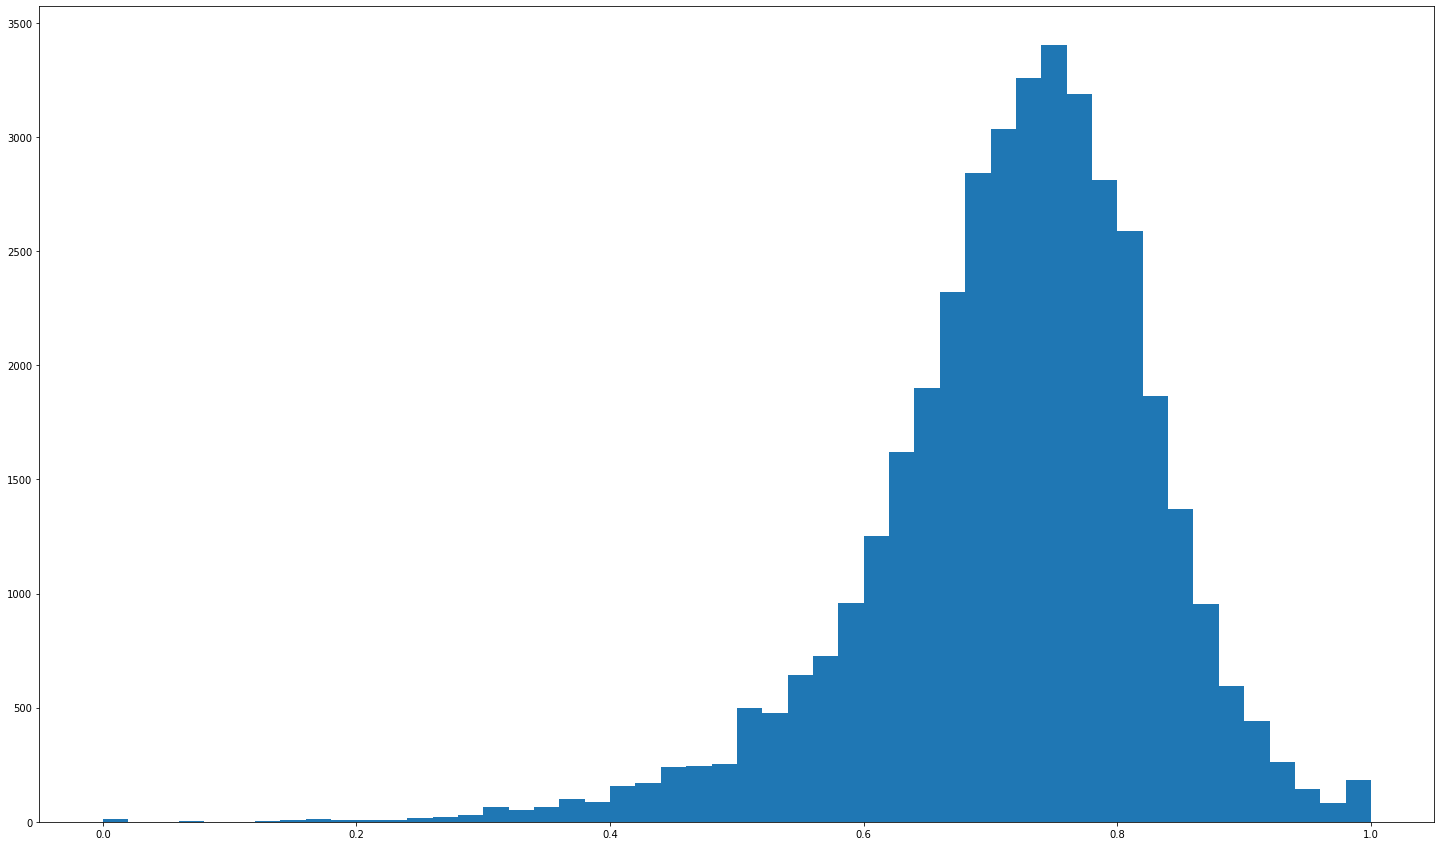

In [58]:
perf = test(y_test, pred)

## Ameliorations

add context on lecture and tasks

cluster lecture and tasks

give average score of a given task

enhance test set with train set (optimization constraint)
